In [4]:
import ptsFromCAD as pfc
import meshingComponents as mc
import geometricClasses as gcl
import loadModel as lm

import pyfe3d.beamprop as pbp
import pyfe3d.shellprop_utils as psp
import pyfe3d as pf3

import pyfe3Dgcl as p3g

import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import scipy.sparse.linalg as ssl
import copy

Definitions

In [17]:
#constants/givens
BAT_MASS_1WING = 17480 #kg
E = 72e9 #Pa
NU = .33 #[-]
RHO = 2700 #kg/m^3
RHO_STEEL = 7850 #kg/m^3 #TODO: verify
E_STEEL = 200e9 #Pa #TODO: verif
FULLSPAN = 21 #m
G0 = 9.81 #N/kg
MTOM = 76000 #kg
INFTY_STIFF = 1e20

data = "5000;0;-6.5|4750;0;-24|4500;0;-41|4000;0;-75|3500;0;-107|3000;0;-138|2500;0;-167|2000;0;-190|1500;0;-206|1250;0;-211|1000;0;-211.5|750;0;-205|500;0;-187.5|375;0;-173|250;0;-150.5|125;0;-113.5|62.5;0;-82.5|0;0;0|62.5;0;107.5|125;0;149.5|250;0;206.5|375;0;248|500;0;281.5|750;0;330.5|1000;0;363|1250;0;383.5|1500;0;394|2000;0;390|2500;0;362|3000;0;318|3500;0;259|4000;0;187.5|4500;0;104|4750;0;57|5000;0;6.5&4250;18000;2206.872|4125;18000;2198.122|4000;18000;2189.622|3750;18000;2172.622|3500;18000;2156.622|3250;18000;2141.122|3000;18000;2126.622|2750;18000;2115.122|2500;18000;2107.122|2375;18000;2104.622|2250;18000;2104.372|2125;18000;2107.622|2000;18000;2116.372|1937.5;18000;2123.622|1875;18000;2134.872|1812.5;18000;2153.372|1781.25;18000;2168.872|1750;18000;2210.122|1781.25;18000;2263.872|1812.5;18000;2284.872|1875;18000;2313.372|1937.5;18000;2334.122|2000;18000;2350.872|2125;18000;2375.372|2250;18000;2391.622|2375;18000;2401.872|2500;18000;2407.122|2750;18000;2405.122|3000;18000;2391.122|3250;18000;2369.122|3500;18000;2339.622|3750;18000;2303.872|4000;18000;2262.122|4125;18000;2238.622|4250;18000;2213.372&-471.576;3673.46;441.249|126.713;7770.33;945.522|725.002;11867.2;1449.796|1323.292;15964.069;1954.07&3012.266;18950.167;2324.854|4861.588;5721.895;702.56&500;0;0|1999.77;18000;2214.157&3500;0;0|3499.77;18000;2214.157&787.633;1600;66.192|2883.375;1600;66.192|2617.418;1600;526.843|1053.59;1600;526.843&2024.321;18000;2152.592|3273.646;18000;2152.592|3148.758;18000;2368.903|2149.209;18000;2368.903" 
up = pfc.UnpackedPoints(data)
mesh = gcl.Mesh3D()

#mesh settings
nb = 50
na = 7
nf2 = 3
ntrig = 2
nipCoeff = 1

#geometry settings
dz = .015 #inwards z offset of battery rail
din = .010 #inner diameter of (threaded) battery rail
cspacing = .25 #chordwise panel rib spacing
bspacing = 2 #spanwise panel rib spacing
ribflange = 0.0125 #rib flange length, excluding bends at corners
motormass = 1000
lgmass = 5000
hingemass = 500
# motmountwidth = 0.7 #width of the motor mount along y

#loads
n = 2.5 #[-], load factor
FT = 5000 #N, per motor
TT = 1400 #Nm, per motor, can be negative depends on direction of spinning

#eleids
spar = "sp"
battery = "bt"
batteryRail = "br"
# batteryMount = "bm"
# railMount = "rm"
panelPlate = "pl"
panelFlange = "fl"
panelRib = "rb"
skin = "sk"
motor = "mo"
lg ="lg"
hinge ="hn"
mount = "mm"

#geometry loading
pts, ids = mc.all_components(mesh, up, nb, na, nf2, nipCoeff, ntrig, dz, din, cspacing, bspacing, BAT_MASS_1WING,
                             spar, panelPlate, panelRib, panelFlange, skin, batteryRail, battery, motor, lg, hinge, mount)

#element definitions
#1) thicknesses
t_spar = 0.005 #thickness of spars and their flanges
t_skin = 0.003 #outer skin thickness
t_plate = 0.0025 #panel plate thickness
t_rib = 0.002 #panel rib thickness

#2) springs
ks_rivet = p3g.SpringProp(1e5, 1e7, 1e7, 1e5, 1e5, 1e5, 0, 0, 1, 0, 1, 1, .01) #rivets are all oriented along z axis
# ks_railmount = (1e7, 1e7, 1e7, 1e7, 1e7, 1e7) #rail to flange mount also oriented along z
# ks_batmount = (1e6, 1e6, 1e6, 1e6, 1e6, 1e6) #battery to rail mount also oriented along z
ks_motmount =  p3g.SpringProp(INFTY_STIFF, INFTY_STIFF, INFTY_STIFF, INFTY_STIFF, INFTY_STIFF, INFTY_STIFF, 2) #TODO: here orientation will be "fun"

#3) beams
prop_rail = p3g.OrientedBeamProp(1, 0, 0)
prop_rail.A = np.pi/4*din**2
prop_rail.Iyy = np.pi/64*din**4
prop_rail.Izz = prop_rail.Iyy
prop_rail.J = prop_rail.Iyy+prop_rail.Izz
scf = 5/6 #ASSUMPTION, TODO: verify
prop_rail.G = scf*E_STEEL/2/(1+0.3)
prop_rail.intrho = RHO_STEEL*prop_rail.A
prop_rail.intrhoy2 = RHO_STEEL*prop_rail.Izz
prop_rail.intrhoz2 = RHO_STEEL*prop_rail.Iyy

#template for the flange prop
prop_flange = p3g.OrientedBeamProp(0, 0, 0)
prop_flange.A = t_rib*ribflange
prop_flange.Izz = t_rib*ribflange**3/12
prop_flange.Iyy = ribflange*t_rib**3/12
scf = 5/6 #ASSUMPTION, TODO: verify
prop_flange.G = scf*E/2/(1+0.3)
prop_flange.intrho = RHO*prop_flange.A
prop_flange.intrhoy2 = RHO*prop_flange.Izz
prop_flange.intrhoz2 = RHO*prop_flange.Iyy

def prop_flange_or(dir): #oriented flange prop
    pfor = copy.deepcopy(prop_flange)
    pfor.xyex = dir[0]
    pfor.xyey = dir[1]
    pfor.xyez = dir[2]
    return pfor

#element dictionary
eleProps = {"quad":{spar:psp.isotropic_plate(thickness=t_spar, E=E, nu=NU, rho=RHO, calc_scf=True), 
                    skin:psp.isotropic_plate(thickness=t_skin, E=E, nu=NU, rho=RHO, calc_scf=True),
                    panelPlate:psp.isotropic_plate(thickness=t_plate, E=E, nu=NU, rho=RHO, calc_scf=True), 
                    panelRib:psp.isotropic_plate(thickness=t_rib, E=E, nu=NU, rho=RHO, calc_scf=True)},
            "spring":{mount:ks_motmount},
            "beam":{batteryRail:prop_rail, panelFlange:prop_flange_or}, 
            "mass":{battery:lambda m:m, motor:motormass, lg:lgmass, hinge:hingemass}}

#exporting mesh to pyfe3d
KC0, M, N, x, y, z, outdict = p3g.eles_from_gcl(mesh, eleProps)


Load Application

In [7]:
#boundary conditions = fix at y of fuselage boundary
bk = np.zeros(N, dtype=bool)
check = np.isclose(y, up.ffb.y)
for i in range(pf3.DOF):
    bk[i::pf3.DOF] = check
bu = ~bk

#loads TODO: add real ones
f = np.zeros(N)

#aerodynamic load
xts, yts, zts = gcl.pts2coords3D(pts["skinTop"].flatten())
xbs, ybs, zbs = gcl.pts2coords3D(pts["skinBot"].flatten())
xtmesh, ytmesh = np.array(xts).reshape(pts["skinTop"].shape).T, np.array(yts).reshape(pts["skinTop"].shape).T
xbmesh, ybmesh = np.array(xbs).reshape(pts["skinBot"].shape).T, np.array(ybs).reshape(pts["skinBot"].shape).T

#lift fractions - will have to get multiplied by an appropriate load case
#lt, mxt, myt, ncxp, ncxm, ncyp, ncym, yPerB2, xPerC = lm.apply_on_wingbox(xtmesh, ytmesh, (up.fft.y/FULLSPAN, up.tft.y/FULLSPAN), (up.xcft, up.xcrt), True, True)
lt, mxt, myt = lm.apply_on_wingbox(xtmesh, ytmesh, (up.fft.y/FULLSPAN, up.tft.y/FULLSPAN), (up.xcft, up.xcrt), True)
lb, mxb, myb = lm.apply_on_wingbox(xbmesh, ybmesh, (up.fft.y/FULLSPAN, up.tft.y/FULLSPAN), (up.xcfb, up.xcrb), False)

#for now, just mul by 2.5*76000*G0
L = n*MTOM*G0
Lt, Mxt, Myt, Lb, Mxb, Myb = L*lt.flatten(), L*mxt.flatten(), L*myb.flatten(), L*lb.flatten(), L*mxb.flatten(), L*myb.flatten()
#applying the top skin loads
for id_, Lt_, Mxt_, Myt_ in zip(ids["skinTop"].flatten(), Lt, Mxt, Myt):
    f[2::pf3.DOF][id_] = Lt_
    f[3::pf3.DOF][id_] = Mxt_
    f[4::pf3.DOF][id_] = Myt_ 
#applying the bottom skin loads
for id_, Lb_, Mxb_, Myb_ in zip(ids["skinBot"].flatten(), Lb, Mxb, Myb):
    f[2::pf3.DOF][id_] = Lb_
    f[3::pf3.DOF][id_] = Mxb_
    f[4::pf3.DOF][id_] = Myb_ 

assert np.isclose(f[2::pf3.DOF].sum(), L/2) #we have to compare with f not fu, cuz in fu part of the lift gets eaten by bce, but that's aight

#applying thrust
for mtr, mid in zip(up.motors, ids["motors"]): #checking coordinate correspondence
    f[0::pf3.DOF][mid[0]] = TT/2
    f[3::pf3.DOF][mid[1]] = TT/2

#applying weight
f+=p3g.weight(M, n*G0, N, pf3.DOF, gcl.Direction3D(0,0,-1))

Solution - This runs a while

In [12]:
#checks and solution
KC0uu = KC0[bu, :][:, bu]
fu = f[bu]
uu = ssl.spsolve(KC0uu, fu)
u = np.zeros(N)
u[bu] = uu

w = u[2::pf3.DOF]
v = u[0::pf3.DOF]

Plots

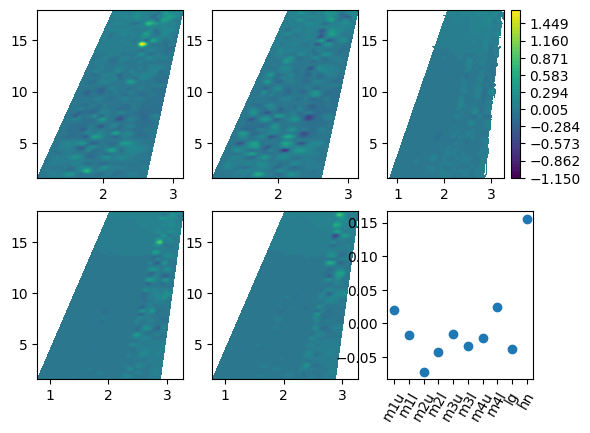

In [ ]:
plt.figure()
plt.tight_layout(pad=3)
levels = np.linspace(w.min(), w.max(), 50)

def contourp(loc:int, compId:str):
    plt.subplot(loc)
    selection = ids[compId]
    sf = selection.flatten()
    plt.contourf(x[sf].reshape(selection.shape), y[sf].reshape(selection.shape), w[sf].reshape(selection.shape), levels=levels)

contourp(231, "plateTop")
contourp(232, "skinTop")
contourp(233, "spars")
plt.colorbar()
contourp(234, "plateBot")
contourp(235, "skinBot")

plt.subplot(236)
x_ = [0,1,2,3,4,5,6,7,8,9]
y_ = [w[ids["motors"][0][0]], w[ids["motors"][0][1]], w[ids["motors"][1][0]], w[ids["motors"][1][1]],
     w[ids["motors"][2][0]], w[ids["motors"][2][1]], w[ids["motors"][3][0]], w[ids["motors"][3][1]],
     w[ids["lg"]], w[ids["hinge"]]]
plt.scatter(x_, y_)
plt.xticks(x_, ["m1u","m1l","m2u","m2l", "m3u", "m3l", 
                           "m4u", "m4l", "lg", "hn"], rotation=60)
plt.show()